# 3.5 Classifying newswires : a multiclass classification example

## 3.5.1 The Reuters dataset

You’ll work with the Reuters dataset, a set of short newswires and their topics, published
by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There
are 46 different topics; some topics are more represented than others, but each topic
has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let’s
take a look.

In [1]:
# Loading the Reuters dataset
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 4s 2us/step


As with the IMDB dataset, the argument num_words=10000 restricts the data to the
10,000 most frequently occurring words found in the data.

You have 8,982 training examples and 2,246 test examples:

In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [4]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here’s how you can decode it back to words, in case you’re curious.

In [6]:
# Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 2s 3us/step


The label associated with an example is an integer between 0 and 45—a topic index:

In [7]:
train_labels[10]

3

## 3.5.2 Preparing the data

You can vectorize the data with the exact same code as in the previous example.

In [8]:
# Encoding the data
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an integer
tensor, or you can use one-hot encoding. One-hot encoding is a widely used format
for categorical data, also called __categorical encoding__. For a more detailed
explanation of one-hot encoding, see section 6.1. In this case, one-hot encoding of
the labels consists of embedding each label as an all-zero vector with a 1 in the place of
the label index. Here’s an example:

In [9]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you’ve already seen in action
in the MNIST example:

In [10]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 3.5.3 Building your network

This topic-classification problem looks similar to the previous movie-review classification
problem: in both cases, you’re trying to classify short snippets of text. But there is
a new constraint here: the number of output classes has gone from 2 to 46. The
dimensionality of the output space is much larger.

In a stack of __Dense__ layers like that you’ve been using, each layer can only access information
present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. In the previous example, you used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason you’ll use larger layers. Let’s go with 64 units.

In [11]:
# Model definition

from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


There are two other things you should note about this architecture:
* You end the network with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a softmax activation. You saw this pattern in the MNIST example. It means the network will output a probability distribution over the 46 different output classes—for every input sample, the network will produce a 46-dimensional output vector, where __output[i]__ is the probability that the sample belongs to class __i__. The 46 scores will sum to 1.

The best loss function to use in this case is __categorical_crossentropy__. It measures
the distance between two probability distributions: here, between the probability distribution
output by the network and the true distribution of the labels. By minimizing
the distance between these two distributions, you train the network to output something
as close as possible to the true labels.

In [12]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## 3.5.4 Validating your approach

Let’s set apart 1,000 samples in the training data to use as a validation set.

In [13]:
# Setting aside a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now, let’s train the network for 20 epochs.

In [14]:
# Training the model
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 369us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7204 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 2s 250us/step - loss: 1.4450 - acc: 0.6878 - val_loss: 1.3457 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 2s 255us/step - loss: 1.0951 - acc: 0.7648 - val_loss: 1.1704 - val_acc: 0.7420
Epoch 4/20
7982/7982 [==============================] - 2s 251us/step - loss: 0.8695 - acc: 0.8161 - val_loss: 1.0795 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 2s 249us/step - loss: 0.7032 - acc: 0.8480 - val_loss: 0.9846 - val_acc: 0.7820
Epoch 6/20
7982/7982 [==============================] - 2s 245us/step - loss: 0.5665 - acc: 0.8795 - val_loss: 0.9409 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 2s 246us/step - loss: 0.4580 - a

And finally, let’s display its loss and accuracy curves

In [15]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

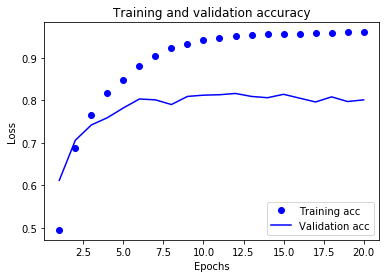

In [16]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The network begins to overfit after nine epochs. Let’s train a new network from scratch for nine epochs and then evaluate it on the test set.

In [17]:
# Retraining a model from scratch
model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 3s 325us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 2s 247us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 2s 253us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 2s 250us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 2s 251us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 2s 246us/step - loss: 0.5124 - acc: 0.8923 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 2s 248us/step - loss: 0.4123 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [18]:
results

[1.022208026977702, 0.7756010686194165]

This approach reaches an accuracy of ~80%. With a balanced binary classification
problem, the accuracy reached by a purely random classifier would be 50%. But in
this case it’s closer to 19%, so the results seem pretty good, at least when compared to
a random baseline:

In [19]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.182546749777382

## 3.5.5 Generating predictions on new data

You can verify that the __predict__ method of the model instance returns a probability
distribution over all 46 topics. Let’s generate topic predictions for all of the test data.

In [20]:
# Generating predictions for new data
predictions = model.predict(x_test)

In [21]:
# Each entry in predictions is a vector of length 46:
predictions[0].shape

(46,)

In [22]:
# The coefficients in this vector sum to 1:
np.sum(predictions[0])

0.9999999

In [23]:
# The largest entry is the predicted class—the class with the highest probability:
np.argmax(predictions[0])

3

## 3.5.6 A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like this:

In [24]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The loss
function used in listing 3.21, categorical_crossentropy, expects the labels to follow
a categorical encoding. With integer labels, you should use sparse_categorical_
crossentropy:

In [25]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically the same as __categorical_crossentropy__;
it just has a different interface.

## 3.5.7 The importance of having sufficiently large intermediate layers

In [26]:
# A model with an information bottleneck

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 453us/step - loss: 2.6576 - acc: 0.3773 - val_loss: 1.9683 - val_acc: 0.5280
Epoch 2/20
7982/7982 [==============================] - 3s 342us/step - loss: 1.6652 - acc: 0.6208 - val_loss: 1.5408 - val_acc: 0.6230
Epoch 3/20
7982/7982 [==============================] - 3s 346us/step - loss: 1.3322 - acc: 0.6706 - val_loss: 1.3942 - val_acc: 0.6790
Epoch 4/20
7982/7982 [==============================] - 3s 347us/step - loss: 1.1418 - acc: 0.7275 - val_loss: 1.3251 - val_acc: 0.6960
Epoch 5/20
7982/7982 [==============================] - 3s 344us/step - loss: 1.0106 - acc: 0.7457 - val_loss: 1.2708 - val_acc: 0.7010
Epoch 6/20
7982/7982 [==============================] - 3s 343us/step - loss: 0.9093 - acc: 0.7578 - val_loss: 1.2763 - val_acc: 0.7080
Epoch 7/20
7982/7982 [==============================] - 3s 346us/step - loss: 0.8299 - acc: 0.7744 - val_loss: 1.2599 - val_acc: 0.7110


The network now peaks at ~89% validation accuracy, an 4% absolute drop. This drop
is mostly due to the fact that you’re trying to compress a lot of information (enough
information to recover the separation hyperplanes of 46 classes) into an intermediate
space that is too low-dimensional. The network is able to cram most of the necessary
information into these eight-dimensional representations, but not all of it.

## 3.5.8 Further experiments

* Try using larger or smaller layers: 32 units, 128 units, and so on.
* You used two hidden layers. Now try using a single hidden layer, or three hidden layers.

## 3.5.9 Wrapping up

Here’s what you should take away from this example:
* If you’re trying to classify data points among N classes, your network should end with a __Dense__ layer of size N.
* In a single-label, multiclass classification problem, your network should end with a __softmax__ activation so that it will output a probability distribution over the N output classes.
* __Categorical crossentropy__ is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network and the true distribution of the targets.
* There are two ways to handle labels in __multiclass classification__: 
  - Encoding the labels via __categorical encoding__ (also known as one-hot encoding) and using __categorical_crossentropy as a loss function__, 
  - Encoding the labels as __integers__ and using the __sparse_categorical_crossentropy loss function__
* If you need to classify data into a large number of categories, you should avoid creating __information bottlenecks__ in your network __due to intermediate layers that are too small__.